Empuxo total ~ 20,736 kgf
Epoch   500 | loss = 2.100e+09
Epoch  1000 | loss = 2.092e+09
Deflexão máxima PINN: 48.096 mm
von Mises máx PINN: 440.79 MPa
Coeficiente A (Ritz 1 termo): 1.439e+01
Deflexão máxima Ritz: 56.199 mm
von Mises máx Ritz: 489.50 MPa


/var/folders/t1/z__864mn4r9_9y7bwfg26w_r0000gn/T/ipykernel_10455/204009429.py:242: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_stiff = np.trapz(np.trapz(integrand_stiff, dx=dxi, axis=1), dx=deta, axis=0) * J
/var/folders/t1/z__864mn4r9_9y7bwfg26w_r0000gn/T/ipykernel_10455/204009429.py:247: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I_load = np.trapz(np.trapz(P * PSI, dx=dxi, axis=1), dx=deta, axis=0) * J


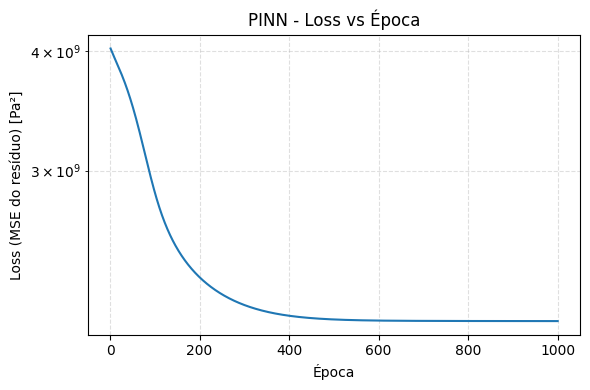

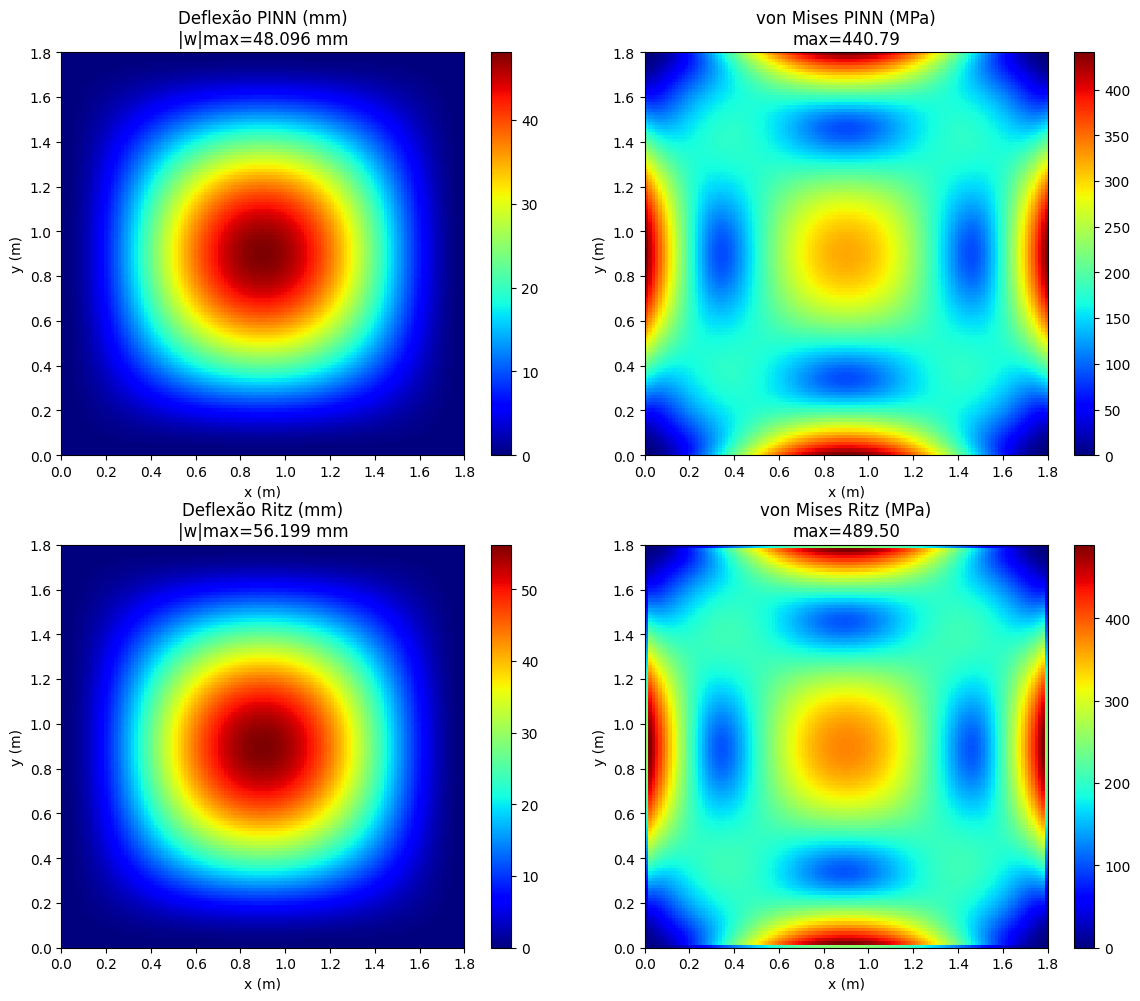

In [ ]:
# PINN placa quadrada engastada sob carga hidrostática
# Versão normalizada [0,1]^2 + LBFGS opcional + comparação Ritz
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

dtype  = torch.float64
device = torch.device("cpu")

# ---------------------------
# Parâmetros físicos (SI)
# ---------------------------
Lx = 1.80   # m
Ly = 1.80   # m
t  = 0.0095 # m
E  = 200e9  # Pa
nu = 0.30

H = 7.30    # m (nível até fundo da abertura)
A = 1.80    # m (altura da abertura)
B = 1.80    # m (largura da abertura)
gamma = 9810.0  # N/m^3 (água)

def p_of_y_phys(y_phys):
    # p(y) = gamma * ((H - A) + y)
    return gamma * ((H - A) + y_phys)

# Rigidez placa
D = E * t**3 / (12.0 * (1.0 - nu**2))

# Empuxo total
W_total = B * gamma * (A*(H - A/2.0))
print(f"Empuxo total ~ {W_total/9.81:,.0f} kgf")

# ---------------------------
# Pontos de colocalização (normalizados)
# ---------------------------
N_int = 1500
Xi  = torch.rand(N_int, 1, dtype=dtype, device=device)  # ξ in [0,1]
Eta = torch.rand(N_int, 1, dtype=dtype, device=device)  # η in [0,1]
XYn = torch.cat([Xi, Eta], dim=1).requires_grad_(True)

# ---------------------------
# Rede + ansatz com CC engastadas (duras)
# ---------------------------
class MLP(nn.Module):
    def __init__(self, hidden=20, depth=3):
        super().__init__()
        layers = []
        last = 2
        for _ in range(depth):
            layers += [nn.Linear(last, hidden), nn.Tanh()]
            last = hidden
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.net(x)

def psi_hat(xi, eta):
    # zero duplo nos quatro lados -> engaste (w=0 e dw/dn=0)
    return (xi**2) * (1.0 - xi)**2 * (eta**2) * (1.0 - eta)**2

net = MLP(hidden=20, depth=3).to(device).to(dtype)

def w_hat_norm(xyn):
    xi  = xyn[:, 0:1]
    eta = xyn[:, 1:2]
    return psi_hat(xi, eta) * net(xyn)  # w em metros

# ---------------------------
# Utilitários de derivadas
# ---------------------------
def grad_scalar(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def biharmonic_normalized(w, xyn, Lx, Ly):
    """
    Retorna o ∇^4 físico a partir de derivadas em coords normalizadas (ξ,η).
    Para geral (retangular):
      ∂/∂x = (1/Lx) ∂/∂ξ , ∂/∂y = (1/Ly) ∂/∂η
      ⇒ ∇^4 = ∂^4/∂x^4 + 2∂^4/∂x^2∂y^2 + ∂^4/∂y^4
            = (1/Lx^4) w_ξξξξ + 2/(Lx^2 Ly^2) w_ξξηη + (1/Ly^4) w_ηηηη
    """
    g1 = grad_scalar(w, xyn)       # [w_ξ, w_η]
    g2x = grad_scalar(g1[:, 0:1], xyn)  # [w_ξξ, w_ξη]
    g2y = grad_scalar(g1[:, 1:2], xyn)  # [w_ηξ, w_ηη]
    w_xixi, w_xieta = g2x[:, 0:1], g2x[:, 1:2]
    w_etaxi, w_etaeta = g2y[:, 0:1], g2y[:, 1:2]

    g3_xixi = grad_scalar(w_xixi, xyn)      # [w_ξξξ, w_ξξη]
    g3_etaeta = grad_scalar(w_etaeta, xyn)  # [w_ηηξ, w_ηηη]
    w_xixixi, w_xixieta = g3_xixi[:, 0:1], g3_xixi[:, 1:2]
    w_etaetaxi, w_etaetaeta = g3_etaeta[:, 0:1], g3_etaeta[:, 1:2]

    g4_xixixi = grad_scalar(w_xixixi, xyn)        # [w_ξξξξ, ...]
    g4_etaetaeta = grad_scalar(w_etaetaeta, xyn)  # [..., w_ηηηη]
    w_xixixixi = g4_xixixi[:, 0:1]
    w_etaetaetaeta = g4_etaetaeta[:, 1:2]

    # w_ξξηη (duas vias -> média para estabilidade)
    g4_xixieta = grad_scalar(w_xixieta, xyn)      # [w_ξξηξ, w_ξξηη]
    g4_etaetaxi = grad_scalar(w_etaetaxi, xyn)    # [w_ηηξξ, w_ηηξη]
    w_xixietaeta_a = g4_xixieta[:, 1:2]
    w_xixietaeta_b = g4_etaetaxi[:, 0:1]
    w_xixietaeta = 0.5*(w_xixietaeta_a + w_xixietaeta_b)

    term_x = (1.0 / Lx**4) * w_xixixixi
    term_y = (1.0 / Ly**4) * w_etaetaetaeta
    term_xy = 2.0 / (Lx**2 * Ly**2) * w_xixietaeta
    return term_x + term_xy + term_y

# ---------------------------
# Loss (PDE somente; CC são "duras")
# ---------------------------
def pinn_loss(xyn):
    w = w_hat_norm(xyn)
    bih = biharmonic_normalized(w, xyn, Lx, Ly)     # ∇^4 físico
    y_phys = xyn[:, 1:2] * Ly
    p = p_of_y_phys(y_phys)
    res = D * bih - p
    return torch.mean(res**2)

# ---------------------------
# Treino: Adam (+ LBFGS opcional)
# ---------------------------
history = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
EPOCHS = 1000

for ep in range(1, EPOCHS+1):
    opt.zero_grad()
    loss = pinn_loss(XYn)
    loss.backward()
    opt.step()
    history.append(loss.item())
    if ep % 500 == 0:
        print(f"Epoch {ep:5d} | loss = {loss.item():.3e}")

# ---- LBFGS opcional (refino) -----------------------------------------------
# lbfgs = torch.optim.LBFGS(net.parameters(), max_iter=600, history_size=50, line_search_fn='strong_wolfe')
# def closure():
#     lbfgs.zero_grad()
#     l = pinn_loss(XYn)
#     l.backward()
#     return l
# l_final = lbfgs.step(closure)
# print("LBFGS final loss:", float(l_final))
# ---------------------------------------------------------------------------

# ---------------------------
# Pós-processamento PINN
# ---------------------------
Nx = 121; Ny = 121
xi  = np.linspace(0.0, 1.0, Nx)
eta = np.linspace(0.0, 1.0, Ny)
XI, ETA = np.meshgrid(xi, eta, indexing="xy")

XYg = torch.tensor(np.c_[XI.ravel(), ETA.ravel()], dtype=dtype, device=device).requires_grad_(True)
w_g = w_hat_norm(XYg)

# deflexão
W_pinn = w_g.detach().cpu().numpy().reshape(Ny, Nx)

# segundas derivadas em coords normalizadas
g1 = grad_scalar(w_g, XYg)
g2x = grad_scalar(g1[:, 0:1], XYg)  # [w_ξξ, w_ξη]
g2y = grad_scalar(g1[:, 1:2], XYg)  # [w_ηξ, w_ηη]
w_xixi  = g2x[:, 0:1]
w_xieta = g2x[:, 1:2]
w_etaeta = g2y[:, 1:2]

# converter para derivadas físicas
w_xx = (1.0 / Lx**2) * w_xixi
w_yy = (1.0 / Ly**2) * w_etaeta
w_xy = (1.0 / (Lx * Ly)) * w_xieta

Mx = -D * (w_xx + nu * w_yy)
My = -D * (w_yy + nu * w_xx)
Mxy = -D * (1.0 - nu) * w_xy

sigma_x = 6.0 * Mx / (t**2)
sigma_y = 6.0 * My / (t**2)
tau_xy  = 6.0 * Mxy / (t**2)
VM_pinn = torch.sqrt(sigma_x**2 + sigma_y**2 - sigma_x*sigma_y + 3.0*tau_xy**2).detach().cpu().numpy().reshape(Ny, Nx)

wmax_pinn = float(np.min(W_pinn))
wmax_pinn_mm = float(np.max(np.abs(W_pinn[1:-1, 1:-1]))*1e3)
print(f"Deflexão máxima PINN: {wmax_pinn_mm:.3f} mm")
print(f"von Mises máx PINN: {np.max(VM_pinn)/1e6:.2f} MPa")

# ---------------------------
# Referência Ritz (1 termo) em domínio normalizado
# ---------------------------
def psi_np(xi, eta):
    return (xi**2) * (1.0 - xi)**2 * (eta**2) * (1.0 - eta)**2

def ritz_A(nx=401, ny=401):
    xi  = np.linspace(0, 1, nx)
    eta = np.linspace(0, 1, ny)
    XI, ETA = np.meshgrid(xi, eta, indexing="xy")
    dxi  = xi[1]  - xi[0]
    deta = eta[1] - eta[0]

    PSI = psi_np(XI, ETA)

    # derivadas em coords normalizadas (dif. finitas)
    def d2_norm(Z, axis, h):
        if axis == 1:  # ξ
            return (np.roll(Z, -1, axis=1) - 2*Z + np.roll(Z, 1, axis=1)) / h**2
        else:          # η
            return (np.roll(Z, -1, axis=0) - 2*Z + np.roll(Z, 1, axis=0)) / h**2

    PSI_xixi  = d2_norm(PSI, axis=1, h=dxi)
    PSI_etaeta= d2_norm(PSI, axis=0, h=deta)
    # mista em normalizado
    PSI_xieta = (np.roll(np.roll(PSI, -1, axis=0), -1, axis=1)
                - np.roll(PSI, -1, axis=0)
                - np.roll(PSI, -1, axis=1)
                + PSI) / (dxi * deta)

    # converter para derivadas físicas 2ª ordem
    PSI_xx  = (1.0 / Lx**2) * PSI_xixi
    PSI_yy  = (1.0 / Ly**2) * PSI_etaeta
    PSI_xy  = (1.0 / (Lx * Ly)) * PSI_xieta

    # energia de flexão (forma padrão usando laplaciano e termo misto)
    lap = PSI_xx + PSI_yy
    integrand_stiff = (lap**2 - 2.0*(1.0 - nu)*(PSI_xx*PSI_yy - PSI_xy**2))

    # Jacobiano da mudança de variável: dx dy = Lx Ly dξ dη
    J = Lx * Ly
    I_stiff = np.trapz(np.trapz(integrand_stiff, dx=dxi, axis=1), dx=deta, axis=0) * J

    # carga
    Y_phys = ETA * Ly
    P = p_of_y_phys(Y_phys)
    I_load = np.trapz(np.trapz(P * PSI, dx=dxi, axis=1), dx=deta, axis=0) * J

    Acoef = I_load / (D * I_stiff)
    return Acoef

Acoef = ritz_A()
print(f"Coeficiente A (Ritz 1 termo): {Acoef:.3e}")

# campo Ritz e tensões
PSI_grid = psi_np(XI, ETA)
W_ritz = Acoef * PSI_grid

# derivadas 2ª em normalizado (para converter a físico)
dxi = xi[1] - xi[0]; deta = eta[1] - eta[0]
def d2_norm_np(Z, axis, h):
    if axis == 1:  # ξ
        return (np.roll(Z, -1, axis=1) - 2*Z + np.roll(Z, 1, axis=1)) / h**2
    else:          # η
        return (np.roll(Z, -1, axis=0) - 2*Z + np.roll(Z, 1, axis=0)) / h**2

W_xixi   = d2_norm_np(W_ritz, axis=1, h=dxi)
W_etaeta = d2_norm_np(W_ritz, axis=0, h=deta)
W_xieta  = (np.roll(np.roll(W_ritz, -1, axis=0), -1, axis=1)
           - np.roll(W_ritz, -1, axis=0)
           - np.roll(W_ritz, -1, axis=1)
           + W_ritz) / (dxi*deta)

W_xx = (1.0 / Lx**2) * W_xixi
W_yy = (1.0 / Ly**2) * W_etaeta
W_xy = (1.0 / (Lx * Ly)) * W_xieta

Mx_r  = -D * (W_xx + nu * W_yy)
My_r  = -D * (W_yy + nu * W_xx)
Mxy_r = -D * (1.0 - nu) * W_xy

sigx_r  = 6.0 * Mx_r  / (t**2)
sigy_r  = 6.0 * My_r  / (t**2)
tauxy_r = 6.0 * Mxy_r / (t**2)
VM_ritz = np.sqrt(sigx_r**2 + sigy_r**2 - sigx_r*sigy_r + 3.0*tauxy_r**2)
wmax_ritz_mm = float(np.max(np.abs(W_ritz[1:-1, 1:-1]))*1e3)

print(f"Deflexão máxima Ritz: {wmax_ritz_mm:.3f} mm")
print(f"von Mises máx Ritz: {np.max(VM_ritz)/1e6:.2f} MPa")

# ---------------------------
# Plots
# ---------------------------
# Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(1, len(history)+1), history)
plt.xlabel("Época")
plt.ylabel("Loss (MSE do resíduo) [Pa²]")
plt.title("PINN - Loss vs Época")
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

im1 = axs[0,0].imshow(W_pinn*1e3, extent=[0,Lx,0,Ly], origin='lower', cmap='jet', aspect='equal')
axs[0,0].set_title(f"Deflexão PINN (mm)\n|w|max={np.max(np.abs(W_pinn[1:-1,1:-1]))*1e3:.3f} mm")
axs[0,0].set_xlabel("x (m)"); axs[0,0].set_ylabel("y (m)")
fig.colorbar(im1, ax=axs[0,0])

im2 = axs[0,1].imshow(VM_pinn/1e6, extent=[0,Lx,0,Ly], origin='lower', cmap='jet', aspect='equal')
axs[0,1].set_title(f"von Mises PINN (MPa)\nmax={np.max(VM_pinn)/1e6:.2f}")
axs[0,1].set_xlabel("x (m)"); axs[0,1].set_ylabel("y (m)")
fig.colorbar(im2, ax=axs[0,1])

im3 = axs[1,0].imshow(W_ritz*1e3, extent=[0,Lx,0,Ly], origin='lower', cmap='jet', aspect='equal')
axs[1,0].set_title(f"Deflexão Ritz (mm)\n|w|max={np.max(np.abs(W_ritz[1:-1,1:-1]))*1e3:.3f} mm")
axs[1,0].set_xlabel("x (m)"); axs[1,0].set_ylabel("y (m)")
fig.colorbar(im3, ax=axs[1,0])

im4 = axs[1,1].imshow(VM_ritz/1e6, extent=[0,Lx,0,Ly], origin='lower', cmap='jet', aspect='equal')
axs[1,1].set_title(f"von Mises Ritz (MPa)\nmax={np.max(VM_ritz)/1e6:.2f}")
axs[1,1].set_xlabel("x (m)"); axs[1,1].set_ylabel("y (m)")
fig.colorbar(im4, ax=axs[1,1])

plt.tight_layout()
plt.show()
